# MLWorkbench Magics

The MLWorkbench Magics are a set of Datalab magic functions that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

When the dataset is small (like this one), there is little benefit of using cloud services. This notebook will run the analyze, transform, and training steps locally. However, we will take the locally trained model and deploy it to ML Engine and show how to make real predictions on a deployed model. Every MLWorkbench magic can run locally or use cloud services.

If you changed the WORKSPACE_PATH variable in the previous notebook, you must also change it here. If you made no modifications, there is no need to update the next cell. The previous notebook must be executed before this one.

In [1]:
WORKSPACE_PATH = '/content/datalab/workspace/structured_data_classification_stackoverflow'

As we will deploy a model to ML Engine, we also need a GCS bucket location to save files. The bucket name needs to be unique. Please rename the following bucket if it exists.

In [2]:
# Make a bucket name. This bucket name should not exist.
gcs_bucket = 'gs://' + datalab_project_id() + '-mlworkbench-stackoverflow-lab' # Feel free to change this

In [3]:
import os
import csv
import re
import pandas as pd
import six
import string
import random
import numpy as np
import json

In [4]:
# Clean data 
clean_folder = os.path.join(WORKSPACE_PATH, 'clean_input')
train_data_path = os.path.join(clean_folder, 'train.csv')
eval_data_path = os.path.join(clean_folder, 'eval.csv')
schema_path = os.path.join(clean_folder, 'schema.json')
transform_path = os.path.join(clean_folder, 'transforms.json')

# For analyze step
analyze_output = os.path.join(WORKSPACE_PATH, 'analyze_output')

# For the transform step
transform_output = os.path.join(WORKSPACE_PATH, 'transform_output')
transformed_train_pattern = os.path.join(transform_output, 'features_train*')
transformed_eval_pattern = os.path.join(transform_output, 'features_eval*')

# For the training step
training_output = os.path.join(WORKSPACE_PATH, 'training_output')

# For the prediction steps
batch_predict_output = os.path.join(WORKSPACE_PATH, 'batch_predict_output')
evaluation_model = os.path.join(training_output, 'evaluation_model')
regular_model = os.path.join(training_output, 'model')

# For depolying the model
mlengine_model_name = 'stackoverflowmodel'
mlengine_version_name = 'example'
mlengine_full_name =  mlengine_model_name + '.' + mlengine_version_name

In [5]:
assert os.path.isfile(train_data_path) and os.path.isfile(eval_data_path)

In [6]:
# Load the features and schema into memory
with open(schema_path) as f:
    schema = json.loads(f.read())
  
with open(transform_path) as f:
    transforms = json.loads(f.read())

# Step 1: Analyze the csv file

The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. The analyze step will compute the vocabularies for the categorical columns and related statistics for the numerical columns. These values are used during training.

Note that in the YAML, we use the '\$var_name' pattern. Datalab will automatically include the values of python variables in the YAML if they start with '\$'.

In [7]:
import google.datalab.contrib.mlworkbench.commands # this loads the %%ml commands

In [8]:
%%ml analyze
output: $analyze_output
training_data:
    csv: $train_data_path
    schema: $schema
features: $transforms

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/workspace/structured_data_classification_stackoverflow/clean_input/train.csv...
file /content/datalab/workspace/structured_data_classification_stackoverflow/clean_input/train.csv analyzed.


In [9]:
!ls $analyze_output

features.json
schema.json
stats.json
vocab_AnnoyingUI.csv
vocab_AssessJobCommute.csv
vocab_AssessJobCompensation.csv
vocab_AssessJobDept.csv
vocab_AssessJobDiversity.csv
vocab_AssessJobExp.csv
vocab_AssessJobFinances.csv
vocab_AssessJobIndustry.csv
vocab_AssessJobLeaders.csv
vocab_AssessJobOffice.csv
vocab_AssessJobProduct.csv
vocab_AssessJobProfDevel.csv
vocab_AssessJobProjects.csv
vocab_AssessJobRemote.csv
vocab_AssessJobRole.csv
vocab_AssessJobTech.csv
vocab_AuditoryEnvironment.csv
vocab_BoringDetails.csv
vocab_BuildingThings.csv
vocab_ChallengeMyself.csv
vocab_ChangeWorld.csv
vocab_CheckInCode.csv
vocab_ClickyKeys.csv
vocab_CollaborateRemote.csv
vocab_CompanySize.csv
vocab_CompanyType.csv
vocab_CompetePeers.csv
vocab_Country.csv
vocab_CousinEducation.csv
vocab_Currency.csv
vocab_DeveloperType.csv
vocab_DifficultCommunication.csv
vocab_DiversityImportant.csv
vocab_EducationImportant.csv
vocab_EducationTypes.csv
vocab_EmploymentStatus.csv
vocab_EnjoyDebugging.csv
vocab_EquipmentSatis

# Step 2: Transforming the input data

This step is only required if the input data has an image path column. The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocall buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can improve training performance. 

Because the data is small, and other ML Workbench samples perform the transform step, this notebook will skip this step. Training will start from the cleaned csv files. 

However, we will still run the transformation cells below (which should take only a few minutes). As an exercise, modify the training step to use the preprocessed files!

In [10]:
!rm -r -f $transform_output

In [11]:
%%ml transform
output: $transform_output
analysis: $analyze_output
prefix: features_train
training_data:
    csv: $train_data_path

2017-07-26 18:33:06.785468: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:33:06.785514: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:33:06.785545: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:33:06.785567: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:33:06.785583: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [12]:
%%ml transform
output: $transform_output
analysis: $analyze_output
prefix: features_eval
training_data:
    csv: $eval_data_path

2017-07-26 18:36:14.824544: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:36:14.824592: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:36:14.824603: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:36:14.824611: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-26 18:36:14.824620: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [13]:
# Let's look at the output
!ls $transform_output

errors_features_eval-00000-of-00001.txt
errors_features_train-00000-of-00001.txt
features_eval-00000-of-00011.tfrecord.gz
features_eval-00001-of-00011.tfrecord.gz
features_eval-00002-of-00011.tfrecord.gz
features_eval-00003-of-00011.tfrecord.gz
features_eval-00004-of-00011.tfrecord.gz
features_eval-00005-of-00011.tfrecord.gz
features_eval-00006-of-00011.tfrecord.gz
features_eval-00007-of-00011.tfrecord.gz
features_eval-00008-of-00011.tfrecord.gz
features_eval-00009-of-00011.tfrecord.gz
features_eval-00010-of-00011.tfrecord.gz
features_train-00000-of-00041.tfrecord.gz
features_train-00001-of-00041.tfrecord.gz
features_train-00002-of-00041.tfrecord.gz
features_train-00003-of-00041.tfrecord.gz
features_train-00004-of-00041.tfrecord.gz
features_train-00005-of-00041.tfrecord.gz
features_train-00006-of-00041.tfrecord.gz
features_train-00007-of-00041.tfrecord.gz
features_train-00008-of-00041.tfrecord.gz
features_train-00009-of-00041.tfrecord.gz
features_train-00010-of-00041.tfrecord.gz
featur

In [14]:
# Error files are written even if there are no errors.
# Check that they are empty
!wc -l $transform_output/errors*

0 /content/datalab/workspace/structured_data_classification_stackoverflow/transform_output/errors_features_eval-00000-of-00001.txt
0 /content/datalab/workspace/structured_data_classification_stackoverflow/transform_output/errors_features_train-00000-of-00001.txt
0 total


# Step 3: Training

MLWorkbench automatically builds standard TensorFlow models without you having to write any TensorFlow code. The command below starts training from the cleaned csv files.

As an exercise, run training again with the preprocessed files from the training step and note any performance differences. (Hint: there should be an improvement when using transformed files, but it will be small because the dataset is small. Model accuracy should be similar, but not guaranteed to be the same). To do this, replace "csv: \$train_data_path" with "transformed: \$transformed_train_pattern" in the training cell (and do the same for evaluation_data), and then run the next two cells.

The '%time' magic will output the running time of the cell.

In [15]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!rm -fr $training_output

In [16]:
%time
%%ml train
output: $training_output
analysis: $analyze_output
training_data:
    csv: $train_data_path
evaluation_data:
    csv: $eval_data_path
model_args:
    model: dnn_classification
    hidden-layer-size1: 100
    max-steps: 5000
    top-n: 2
    save-checkpoints-secs: 60

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f75f627ed90>, '_model_dir': '/content/datalab/workspace/structured_data_classification_stackoverflow/training_output/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope the

# Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is good for large datasets where the data cannot fit in memory or when you want to limit peak memory usage.

In [17]:
%%ml batch_predict
model: $evaluation_model
output: $batch_predict_output
format: csv
prediction_data:
  csv: $eval_data_path

local prediction...
INFO:tensorflow:Restoring parameters from /content/datalab/workspace/structured_data_classification_stackoverflow/training_output/evaluation_model/variables/variables
done.


In [18]:
!ls $batch_predict_output

predict_results_eval.csv  predict_results_schema.json


In [19]:
!cat $batch_predict_output/predict_results_schema.json

[
  {
    "type": "INTEGER", 
    "name": "Respondent"
  }, 
  {
    "type": "STRING", 
    "name": "predicted"
  }, 
  {
    "type": "STRING", 
    "name": "predicted_2"
  }, 
  {
    "type": "FLOAT", 
    "name": "probability"
  }, 
  {
    "type": "FLOAT", 
    "name": "probability_2"
  }, 
  {
    "type": "STRING", 
    "name": "target"
  }
]

In [20]:
# Read the schema file
with open(os.path.join(batch_predict_output, 'predict_results_schema.json')) as f:
  predict_schema = json.loads(f.read())

                                                      precision    recall  f1-score   support

                                       None of these       0.69      0.64      0.67       199
                              Professional developer       1.00      1.00      1.00      7269
Professional non-developer who sometimes writes code       0.99      0.99      0.99      1042
                                             Student       0.95      0.96      0.96      1690
                 Used to be a professional developer       1.00      0.97      0.99       195

                                         avg / total       0.99      0.99      0.99     10395

Accuracy
0.985377585378


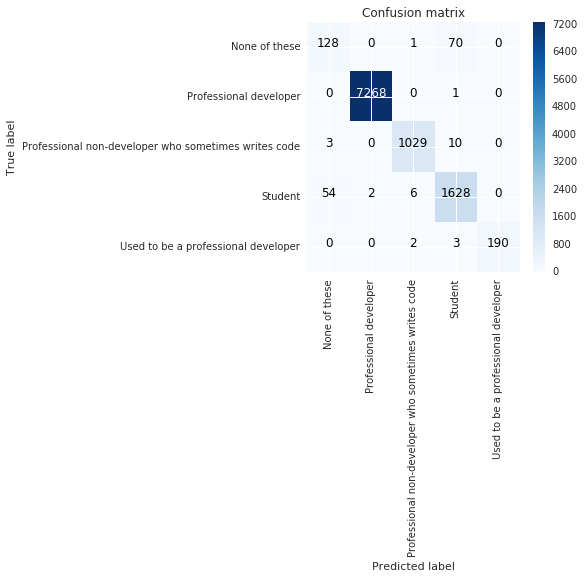

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from google.datalab.ml import ConfusionMatrix

# Read the prediciton results
prediction_results = pd.read_csv(
    os.path.join(batch_predict_output, 'predict_results_eval.csv'),
    header=None,
    names=[col['name'] for col in predict_schema])
y_predicted = prediction_results['predicted'].tolist()
y_true = prediction_results['target'].tolist()
classes = sorted(list(set(y_predicted + y_true)))

# print precision and recall
print(classification_report(y_true, y_predicted, target_names=classes))

# print a confusion matrix using a Datalab function
cm = confusion_matrix(y_true, y_predicted, classes)
ConfusionMatrix(cm, classes).plot(figsize=(8,8), rotation=90)

print('Accuracy')
print(sum([1 for a, b in zip(y_true, y_predicted) if a == b])/float(len(y_true)))

# Step 5: Instant prediction

The MLWorkbench also supports running prediction and displaying the results within the notebook. Note that we use the non-evaluation model below, so the target column is removed.

In [22]:
!head $eval_data_path -n 3

1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,,,,,2 to 3 years,,,,,,,,,,,,,,,,,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock_options Vacation/days_off Remote_options,Yes,Other,,,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,,,Tabs,,Online_course Open_source_contributions,,,,6:00 AM,Swift,Swift,,,,,iOS,iOS,Atom Xcode,Turn on some music,,,,,,,,,,,,Some

In [23]:
headers_string = ','.join([x['name'] for x in schema if x['name'] != schema[1]['name']])

Feel free to copy the 3 rows above into the prediction list below, but don't forget to remove the target column (the 2nd column). Note that the column order must batch what was used during training.

In [24]:
%%ml predict
model: $regular_model
headers: $headers_string
prediction_data:
    - 1,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,,,,,2 to 3 years,,,,,,,,,,,,,,,,,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock_options Vacation/days_off Remote_options,Yes,Other,,,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,,,Tabs,,Online_course Open_source_contributions,,,,6:00 AM,Swift,Swift,,,,,iOS,iOS,Atom Xcode,Turn on some music,,,,,,,,,,,,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,,,,,,,,,,,,I have created a CV or Developer Story on Stack Overflow,9.0,Desktop iOS_app,At least once each week,Haven't done at all,Once or twice,Haven't done at all,Haven't done at all,Several times,Several times,Once or twice,Somewhat agree,Strongly disagree,Strongly disagree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly disagree,Male,High school,White_or_of_European_descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,,
    - 7,"Yes, both",United States,No,Employed full-time,Master's degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day each week",20 to 99 employees,Government agency or public school/university,9 to 10 years,8 to 9 years,,,,,Data_scientist,7.0,6.0,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,"I'm not actively looking, but I am open to new opportunities",1.0,More than 4 years ago,Somewhat important,Very important,Not very important,Important,Important,Very important,Important,Important,Important,Very important,Very important,Very important,Somewhat important,Not very important,Very important,Health_benefits Equipment Professional_development_sponsorship Education_sponsorship Remote_options,Yes,,,"A friend, family member, or former colleague told me",Very important,Important,Important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Not very important,Very important,,,Spaces,,Online_course Part-time/evening_course On-the-job_training Self-taught Open_source_contributions,Official_documentation Trade_book Textbook Stack_Overflow_Q&A Friends_network Built-in_help,,,7:00 AM,Matlab Python,JavaScript Julia Matlab Python R SQL,,Hadoop Node.js,SQLite,MongoDB SQL_Server PostgreSQL SQLite,Windows_Desktop,Arduino Raspberry_Pi,Sublime_Text IPython_/_Jupyter Visual_Studio_Code,Turn on some music,,,,,,,,,,,,Satisfied,Very satisfied,Very satisfied,Satisfied,Satisfied,Very satisfied,Some influence,No influence at all,Not much influence,Not much influence,A lot of influence,A lot of influence,Some influence,No influence at all,No influence at all,No influence at all,Not much influence,I have created a CV or Developer Story on Stack Overflow,8.0,Desktop iOS_browser iOS_app,Several times,Once or twice,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,Several times,At least once each day,Somewhat agree,Disagree,Disagree,Agree,Agree,Strongly agree,Agree,Disagree,Male,A doctoral degree,White_or_of_European_descent,Disagree,Agree,Disagree,Agree,,
    - 14,"Yes, both",Germany,No,Employed full-time,Some college/university study without earning a bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day each week",Fewer than 10 employees,Venture-funded startup,15 to 16 years,15 to 16 years,,Web_developer,Full stack Web developer,,,8.0,6.0,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,I am actively looking for a job,3.0,Between 1 and 2 years ago,Somewhat important,Important,Important,Somewhat important,Important,Somewhat important,Important,Somewhat important,Important,Important,Important,Important,Not very important,Important,Important,Stock_options Vacation/days_off Equipment Professional_development_sponsorship Remote_options,Yes,LinkedIn Xing,I was just giving it a regular update,"A friend, family member, or former colleague told me",Somewhat important,Somewhat important,Important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Not very important,Somewhat important,Important,,,Spaces,Not at all important,Part-time/evening_course On-the-job_training Self-taught Coding_competition Hackathon Open_source_contributions,Official_documentation Trade_book Stack_Overflow_Q&A,,,10:00 AM,Java JavaScript Ruby SQL,JavaScript Ruby Rust Swift,React,React,Redis MySQL PostgreSQL,Redis PostgreSQL,Amazon_Web_Services_(AWS),Amazon_Web_Services_(AWS),Vim,Turn on some music,Agile Lean Scrum Extreme Pair Kanban,Git,Multiple times a day,Somewhat agree,Disagree,Disagree,Somewhat agree,Agree,Disagree,Somewhat agree,Customer_satisfaction Benchmarked_product_performance On_time/in_budget Revenue_performance Manager's_rating Peers'_rating Self-rating,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Not very satisfied,A lot of influence,Some influence,I am the final decision maker,I am the final decision maker,I am the final decision maker,A lot of influence,I am the final decision maker,I am the final decision maker,Some influence,A lot of influence,Some influence,I have created a CV or Developer Story on Stack Overflow,10.0,Desktop,Several times,Several times,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,Several times,Haven't done at all,Somewhat agree,Somewhat agree,Disagree,Agree,Strongly agree,Agree,Somewhat agree,Disagree,Female,A master's degree,Hispanic_or_Latino/Latina,Somewhat agree,Agree,Disagree,Strongly agree,,

Respondent,predicted,predicted_2,probability,probability_2,AnnoyingUI,AssessJobCommute,AssessJobCompensation,AssessJobDept,AssessJobDiversity,AssessJobExp,AssessJobFinances,AssessJobIndustry,AssessJobLeaders,AssessJobOffice,AssessJobProduct,AssessJobProfDevel,AssessJobProjects,AssessJobRemote,AssessJobRole,AssessJobTech,AuditoryEnvironment,BoringDetails,BuildingThings,CareerSatisfaction,ChallengeMyself,ChangeWorld,CheckInCode,ClickyKeys,CollaborateRemote,CompanySize,CompanyType,CompetePeers,Country,CousinEducation,Currency,DeveloperType,DifficultCommunication,DiversityImportant,EducationImportant,EducationTypes,EmploymentStatus,EnjoyDebugging,EquipmentSatisfiedCPU,EquipmentSatisfiedMonitors,EquipmentSatisfiedRAM,EquipmentSatisfiedRW,EquipmentSatisfiedStorage,ExCoder10Years,ExCoderActive,ExCoderBalance,ExCoderBelonged,ExCoderNotForMe,ExCoderReturn,ExCoderSkills,ExCoderWillNotCode,ExpectedSalary,FormalEducation,FriendsDevelopers,Gender,HaveWorkedDatabase,HaveWorkedFramework,HaveWorkedLanguage,HaveWorkedPlatform,HighestEducationParents,HomeRemote,HoursPerWeek,IDE,ImportantBenefits,ImportantHiringAlgorithms,ImportantHiringCommunication,ImportantHiringCompanies,ImportantHiringEducation,ImportantHiringGettingThingsDone,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringRep,ImportantHiringTechExp,ImportantHiringTitles,InTheZone,InfluenceCloud,InfluenceCommunication,InfluenceConsultants,InfluenceDatabase,InfluenceDeptTech,InfluenceHardware,InfluenceInternet,InfluenceRecruitment,InfluenceServers,InfluenceTechStack,InfluenceVizTools,InfluenceWorkstation,InterestedAnswers,InvestTimeTools,JobProfile,JobSatisfaction,JobSecurity,JobSeekingStatus,KinshipDevelopers,LastNewJob,LearnedHiring,LearningNewTech,MajorUndergrad,Methodology,MetricAssess,MobileDeveloperType,NonDeveloperType,OtherPeoplesCode,Overpaid,ProblemSolving,ProgramHobby,ProjectManagement,PronounceGIF,QuestionsConfusing,QuestionsInteresting,Race,ResumePrompted,RightWrongWay,Salary,SelfTaughtTypes,SeriousWork,ShipIt,StackOverflowAdsDistracting,StackOverflowAdsRelevant,StackOverflowAnswer,StackOverflowBetter,StackOverflowCommunity,StackOverflowCompanyPage,StackOverflowCopiedCode,StackOverflowDescribes,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowHelpful,StackOverflowJobListing,StackOverflowJobSearch,StackOverflowMakeMoney,StackOverflowMetaChat,StackOverflowModeration,StackOverflowNewQuestion,StackOverflowSatisfaction,StackOverflowWhatDo,SurveyLong,TabsSpaces,TimeAfterBootcamp,UnderstandComputers,University,VersionControl,WantWorkDatabase,WantWorkFramework,WantWorkLanguage,WantWorkPlatform,WebDeveloperType,WorkPayCare,WorkStart,YearsCodedJob,YearsCodedJobPast,YearsProgram
1,Student,None of these,0.824098,1.759011e-01,Agree,Very important,Important,Very important,Somewhat important,Important,Somewhat important,Very important,Very important,Very important,Not very important,Very important,Very important,Very important,Very important,Very important,Turn on some music,Disagree,Strongly agree,,Agree,Agree,,Yes,,,,Disagree,United States,,,,,Agree,,Online_course Open_source_contributions,"Not employed, and not looking for work",,Not very satisfied,Somewhat satisfied,Not at all satisfied,Satisfied,Very satisfied,,,,,,,,,,Secondary school,Disagree,Male,,,Swift,iOS,High school,,0.0,Atom Xcode,Stock_options Vacation/days_off Remot...,Important,Important,Not very important,Not at all important,Very important,Somewhat important,Important,Somewhat important,Important,Not very important,,,,,,,,Not very satisfied,,,,,,Strongly agree,Strongly agree,Other,,Strongly agree,"I'm not actively looking, but I am op...",Agree,Not applicable/ never,,Agree,,,,,,,,Strongly agree,"Yes, both",,"With a soft ""g,"" like ""jiff""",Disagree,Strongly agree,White_or_of_European_descent,,Somewhat agree,,,Strongly agree,,Strongly disagree,Somewhat agree,Several times,Strongly agree,Strongly agree,Haven't done at all,Haven't done at all,I have created a CV or Developer Stor...,Desktop iOS_app,At 

# Deploying the trained model to ML Engine¶

Now that we have a trained model, have analyzed the results, and have tested the model output locally, we are ready to deploy it to the cloud for real predictions. Deploying a model requires the files are on GCS. The next few cells makes a bucket on GCS, copies the locally trained model, and deploys it.

In [25]:
# Make a bucket. Bucket names must be unique.
!gsutil mb $gcs_bucket

Creating gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/...


In [26]:
# Move the regular model to GCS
!gsutil -m cp -r $regular_model $gcs_bucket

Copying file:///content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/assets.extra/schema.json [Content-Type=application/json]...
Copying file:///content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/assets.extra/features.json [Content-Type=application/json]...
Copying file:///content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [5/5 files][  4.7 MiB/  4.7 MiB] 100% Done                                    
Operation completed over 5 objects/4.7 MiB

In [27]:
# Check the files are there
!gsutil ls -r $gcs_bucket

gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/:
gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/saved_model.pb

gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/assets.extra/:
gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/assets.extra/features.json
gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/assets.extra/schema.json

gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/variables/:
gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/variables/variables.data-00000-of-00001
gs://cloud-ml-dev-mlworkbench-stackoverflow-lab/model/variables/variables.index


In [28]:
from google.datalab.ml import Models, ModelVersions

In [29]:
# Makes a ML Engine Model
# If the model already exists, skip this cell
Models().create(mlengine_model_name)  

{u'name': u'projects/cloud-ml-dev/models/stackoverflowmodel',
 u'regions': [u'us-central1']}

In [30]:
# Makes a ML Engine Version
ModelVersions(mlengine_model_name).deploy(
    version_name=mlengine_version_name,
    path=os.path.join(gcs_bucket, 'model'),
    runtime_version='1.2')

Waiting for operation "projects/cloud-ml-dev/operations/create_stackoverflowmodel_example-1501094401445"
Done.


## Prediction using APIs Explorer

https://developers.google.com/apis-explorer allows you to send HTTP requests to many Google APIs. This is useful for experimenting with the inputs to a service.

Please visit https://developers.google.com/apis-explorer/#search/ml%20engine/ml/v1/ml.projects.predict and enter the following values for each text box.

In [31]:
# The output of this cell is placed in the name box
# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name=mlengine_model_name,
    version_name=mlengine_version_name)
print('Place the following in the name box')
print(api_path)

Place the following in the name box
projects/cloud-ml-dev/models/stackoverflowmodel/versions/example


The fields text box can be empty.


Click in the request body box, and note a small drop down menu appears in the FAR RIGHT of the input box. Select "Freeform editor". Then enter the following in the request body box.

In [32]:
ex1 = '''1,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,,,,,2 to 3 years,,,,,,,,,,,,,,,,,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock_options Vacation/days_off Remote_options,Yes,Other,,,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,,,Tabs,,Online_course Open_source_contributions,,,,6:00 AM,Swift,Swift,,,,,iOS,iOS,Atom Xcode,Turn on some music,,,,,,,,,,,,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,,,,,,,,,,,,I have created a CV or Developer Story on Stack Overflow,9.0,Desktop iOS_app,At least once each week,Haven't done at all,Once or twice,Haven't done at all,Haven't done at all,Several times,Several times,Once or twice,Somewhat agree,Strongly disagree,Strongly disagree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly disagree,Male,High school,White_or_of_European_descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,,'''
ex2 = '''7,"Yes, both",United States,No,Employed full-time,Master's degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day each week",20 to 99 employees,Government agency or public school/university,9 to 10 years,8 to 9 years,,,,,Data_scientist,7.0,6.0,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,"I'm not actively looking, but I am open to new opportunities",1.0,More than 4 years ago,Somewhat important,Very important,Not very important,Important,Important,Very important,Important,Important,Important,Very important,Very important,Very important,Somewhat important,Not very important,Very important,Health_benefits Equipment Professional_development_sponsorship Education_sponsorship Remote_options,Yes,,,"A friend, family member, or former colleague told me",Very important,Important,Important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Not very important,Very important,,,Spaces,,Online_course Part-time/evening_course On-the-job_training Self-taught Open_source_contributions,Official_documentation Trade_book Textbook Stack_Overflow_Q&A Friends_network Built-in_help,,,7:00 AM,Matlab Python,JavaScript Julia Matlab Python R SQL,,Hadoop Node.js,SQLite,MongoDB SQL_Server PostgreSQL SQLite,Windows_Desktop,Arduino Raspberry_Pi,Sublime_Text IPython_/_Jupyter Visual_Studio_Code,Turn on some music,,,,,,,,,,,,Satisfied,Very satisfied,Very satisfied,Satisfied,Satisfied,Very satisfied,Some influence,No influence at all,Not much influence,Not much influence,A lot of influence,A lot of influence,Some influence,No influence at all,No influence at all,No influence at all,Not much influence,I have created a CV or Developer Story on Stack Overflow,8.0,Desktop iOS_browser iOS_app,Several times,Once or twice,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,Several times,At least once each day,Somewhat agree,Disagree,Disagree,Agree,Agree,Strongly agree,Agree,Disagree,Male,A doctoral degree,White_or_of_European_descent,Disagree,Agree,Disagree,Agree,,'''
ex3 = '''14,"Yes, both",Germany,No,Employed full-time,Some college/university study without earning a bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day each week",Fewer than 10 employees,Venture-funded startup,15 to 16 years,15 to 16 years,,Web_developer,Full stack Web developer,,,8.0,6.0,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,I am actively looking for a job,3.0,Between 1 and 2 years ago,Somewhat important,Important,Important,Somewhat important,Important,Somewhat important,Important,Somewhat important,Important,Important,Important,Important,Not very important,Important,Important,Stock_options Vacation/days_off Equipment Professional_development_sponsorship Remote_options,Yes,LinkedIn Xing,I was just giving it a regular update,"A friend, family member, or former colleague told me",Somewhat important,Somewhat important,Important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Not very important,Somewhat important,Important,,,Spaces,Not at all important,Part-time/evening_course On-the-job_training Self-taught Coding_competition Hackathon Open_source_contributions,Official_documentation Trade_book Stack_Overflow_Q&A,,,10:00 AM,Java JavaScript Ruby SQL,JavaScript Ruby Rust Swift,React,React,Redis MySQL PostgreSQL,Redis PostgreSQL,Amazon_Web_Services_(AWS),Amazon_Web_Services_(AWS),Vim,Turn on some music,Agile Lean Scrum Extreme Pair Kanban,Git,Multiple times a day,Somewhat agree,Disagree,Disagree,Somewhat agree,Agree,Disagree,Somewhat agree,Customer_satisfaction Benchmarked_product_performance On_time/in_budget Revenue_performance Manager's_rating Peers'_rating Self-rating,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Not very satisfied,A lot of influence,Some influence,I am the final decision maker,I am the final decision maker,I am the final decision maker,A lot of influence,I am the final decision maker,I am the final decision maker,Some influence,A lot of influence,Some influence,I have created a CV or Developer Story on Stack Overflow,10.0,Desktop,Several times,Several times,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,Several times,Haven't done at all,Somewhat agree,Somewhat agree,Disagree,Agree,Strongly agree,Agree,Somewhat agree,Disagree,Female,A master's degree,Hispanic_or_Latino/Latina,Somewhat agree,Agree,Disagree,Strongly agree,,'''
data = [ex1, ex2, ex3]
print('Place the following in the request body box')
request = {'instances': data}
print(json.dumps(request))

Place the following in the request body box
{"instances": ["1,\"Yes, both\",United States,No,\"Not employed, and not looking for work\",Secondary school,,,,,2 to 3 years,,,,,,,,,,,,,,,,,\"With a soft \"\"g,\"\" like \"\"jiff\"\"\",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,\"I'm not actively looking, but I am open to new opportunities\",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock_options Vacation/days_off Remote_options,Yes,Other,,,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,,,Tabs,,Online_course Open_source_contributions,,,,6:00 AM,S

Then click the "Authorize and execute" button. The prediction results are returned in the browser

## Prediction from a python client

A common problem is to call a deployed model from different applications. Below is an example of writing a python client to run prediction outside of Datalab.

Covering model permissions topics is outside the scope of this notebook, but for more information see https://cloud.google.com/ml-engine/docs/tutorials/python-guide and https://developers.google.com/identity/protocols/application-default-credentials .

In [33]:

from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name=mlengine_model_name,
    version_name=mlengine_version_name)

# Get application default credentials (possible only if the gcloud tool is
#  configured on your machine). See https://developers.google.com/identity/protocols/application-default-credentials
#  for more info.
credentials = GoogleCredentials.get_application_default()

# Build a representation of the Cloud ML API.
ml = discovery.build('ml', 'v1', credentials=credentials)

# Create a dictionary containing data to predict.
# Note that the data is a list of csv strings.
body = {
    'instances': [ex1, ex2, ex3]}

# Create a request
request = ml.projects().predict(
    name=api_path,
    body=body)

print('The JSON request: \n')
print(request.to_json())

# Make the call.
try:
    response = request.execute()
    print('\nThe response:\n')
    print(json.dumps(response, indent=2))
except errors.HttpError, err:
    # Something went wrong, print out some information.
    print('There was an error. Check the details:')
    print(err._get_reason())

The JSON request: 

{"body": "{\"instances\": [\"1,\\\"Yes, both\\\",United States,No,\\\"Not employed, and not looking for work\\\",Secondary school,,,,,2 to 3 years,,,,,,,,,,,,,,,,,\\\"With a soft \\\"\\\"g,\\\"\\\" like \\\"\\\"jiff\\\"\\\"\\\",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,\\\"I'm not actively looking, but I am open to new opportunities\\\",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock_options Vacation/days_off Remote_options,Yes,Other,,,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,,,Tabs,,Online_course Open_source_contr

## Cleaning up the deployed model

In this section, we remove the deployed model and the bucket that was made. The local files that was made are not deleted by this.

In [ ]:
# Delete the version
ModelVersions(mlengine_model_name).delete(mlengine_version_name)

In [ ]:
# Delete the model
Models().delete(mlengine_model_name)

In [ ]:
# Delete the GCS bucket
!gsutil -m rm -r $gcs_bucket